In [1]:
# %%
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import numpy as np
import os, re, sys
import pickle
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



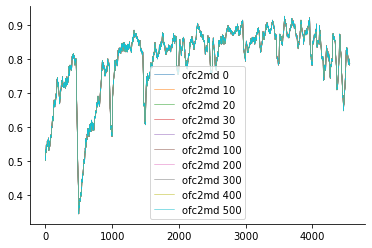

In [65]:

exp_name = 'ofc_no/OFC_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
exps = {0: 'ofc off', 1: 'ofc2md', 2:'ofc2dlPFC', 3:'mul_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
# vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
vars = [(var1, var2) for var1 in [1] for var2 in [0 ,10 ,20, 30, 50,100, 200,300,400, 500]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

ax = plt.gca()
means, stds = [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
# plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)



Text(0.5, 0, 'No of dlPFC neurons receiving OFC signal')

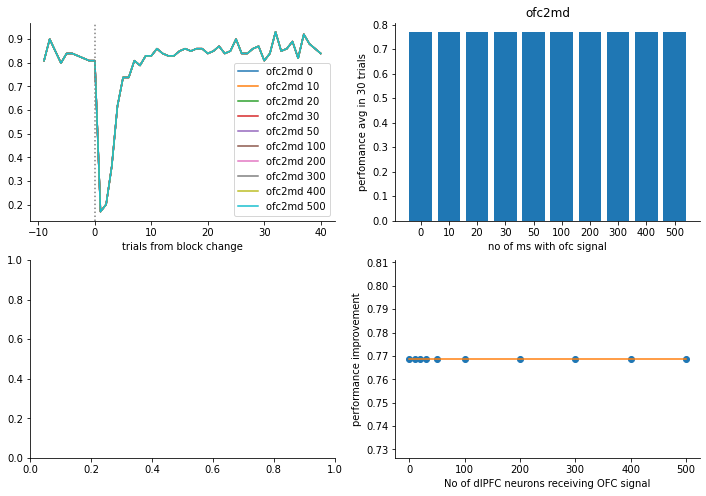

In [66]:
#Isolate and stack change point performance
def get_cp_perf(config, performances, window = 30):
    vt = np.cumsum(config.variable_trials_per_block)[np.array(config.ofc_control_schedule[:len(config.variable_trials_per_block)])=='on']
    vt = vt[:-1] # exclude last entry, just the end trial
    change_perf = [performance[cp-10:cp+window+10] for cp in vt for performance in performances]
    cp = np.vstack(change_perf)
    return(cp)

fig, axes = plt.subplots(2,2, figsize=[12, 8])
window = 30
means, md_modulations =[], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        config = np.load(conf_files[0], allow_pickle=True).item()
        md_modulations.append(config.md_context_modulation)
        cp = get_cp_perf(config, performances, window=window)
        means.append((cp.mean(0)[10:10+window]).mean())
    else:
        means.append(np.nan)
    ax = axes[0,0]
    ax.plot(range(-9, window+11), cp.mean(0) , label=label)
ax.axvline(0, linestyle=':', color='grey')
ax.legend()
ax.set_xlabel('trials from block change')
ax = axes[0,1]
ax.bar([lab[7:] for lab in labels], means)
ax.set_title(exps[vars[0][0]])
ax.set_xlabel('no of ms with ofc signal')
ax.set_ylabel('perfomance avg in 30 trials')

ax = axes[1,1]
no_pfc = [0 ,10 ,20, 30, 50,100, 200,300,400, 500]
ax = plt.gca()
ax.plot(no_pfc, means, 'o')
ax.plot(no_pfc, means, )
ax.set_ylabel('performance improvement')
ax.set_xlabel('No of dlPFC neurons receiving OFC signal')
# plt.savefig('./exports/pfc_no_mul_off.jpg', dpi=300)

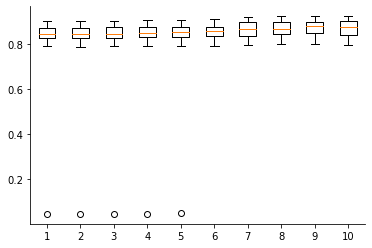

In [63]:
md_modulations = []
for label, regex in zip (labels, regexes):
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(conf_files) > 0:
        mods = []
        for conf_file in conf_files:
            config = np.load(conf_file, allow_pickle=True).item()
            mods.append(config.md_context_modulation)
        md_modulations.append(mods)
_=plt.boxplot(md_modulations)

In [67]:
# means_dlpfc = means
# means_mul_off = means
means_md = means

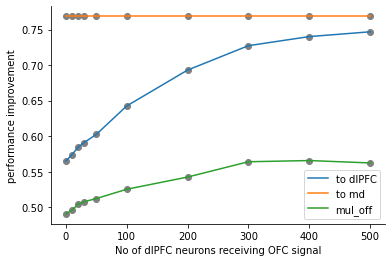

In [69]:
time_steps = [0 ,10 ,20, 30, 50,100, 200,300,400, 500]

ax = plt.gca()
means = means_dlpfc
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label= 'to dlPFC')

means = means_md
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label='to md')

means = means_mul_off
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label='mul_off')
ax.set_ylabel('performance improvement')
ax.set_xlabel('No of dlPFC neurons receiving OFC signal')
# ax.set_xlim([0, 5])
ax.legend()
plt.savefig('./exports/to_md_to_dlpfc_MULOFF_no_dlPFCneurons.jpg', dpi=300)


# Time Steps


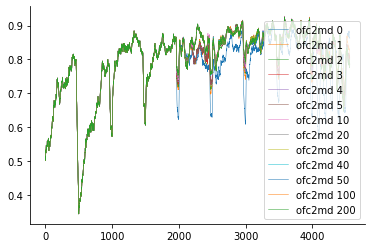

In [50]:

exp_name = 'time_steps/OFC_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]
config_files = [file for file in files if 'config' in file]
exps = {0: 'ofc off', 1: 'ofc2md', 2:'ofc2dlPFC', 3:'mul_off'}
vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

ax = plt.gca()
means, stds = [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
# plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)



Text(0.5, 0, 'timesteps of receiving OFC signal')

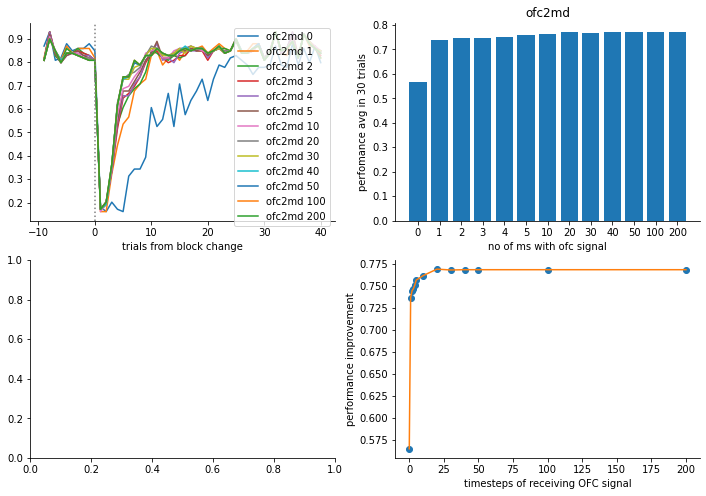

In [51]:
#Isolate and stack change point performance
def get_cp_perf(config, performances, window = 30):
    vt = np.cumsum(config.variable_trials_per_block)[np.array(config.ofc_control_schedule[:len(config.variable_trials_per_block)])=='on']
    vt = vt[:-1] # exclude last entry, just the end trial
    change_perf = [performance[cp-10:cp+window+10] for cp in vt for performance in performances]
    cp = np.vstack(change_perf)
    return(cp)

fig, axes = plt.subplots(2,2, figsize=[12, 8])
window = 30
means, md_modulations =[], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances = [np.load(c1f) for c1f in comp_files]
        config = np.load(conf_files[0], allow_pickle=True).item()
        md_modulations.append(config.md_context_modulation)
        cp = get_cp_perf(config, performances, window=window)
        means.append((cp.mean(0)[10:10+window]).mean())
    else:
        means.append(np.nan)
    ax = axes[0,0]
    ax.plot(range(-9, window+11), cp.mean(0) , label=label)
ax.axvline(0, linestyle=':', color='grey')
ax.legend()
ax.set_xlabel('trials from block change')
ax = axes[0,1]
ax.bar([lab[7:] for lab in labels], means)
ax.set_title(exps[vars[0][0]])
ax.set_xlabel('no of ms with ofc signal')
ax.set_ylabel('perfomance avg in 30 trials')

ax = axes[1,1]
time_steps = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]
ax = plt.gca()
ax.plot(time_steps, means, 'o')
ax.plot(time_steps, means, )
ax.set_ylabel('performance improvement')
ax.set_xlabel('timesteps of receiving OFC signal')
# plt.savefig('./exports/pfc_no_mul_off.jpg', dpi=300)

In [52]:
# means_dlpfc = means
# means_mul_off
# means_md = means

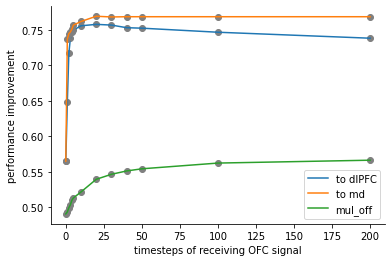

In [57]:
ax = axes[1,1]
time_steps = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 100, 200]
ax = plt.gca()
means = means_dlpfc
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label= 'to dlPFC')

means = means_md
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label='to md')

means = means_mul_off
ax.plot(time_steps, means, 'o', color='grey')
ax.plot(time_steps, means, label='mul_off')
ax.set_ylabel('performance improvement')
ax.set_xlabel('timesteps of receiving OFC signal')
# ax.set_xlim([0, 5])
ax.legend()
plt.savefig('./exports/to_md_to_dlpfc_MULOFF_timestpes.jpg', dpi=300)


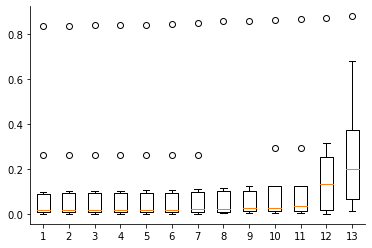

In [42]:
md_modulations = []
for label, regex in zip (labels, regexes):
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(conf_files) > 0:
        mods = []
        for conf_file in conf_files:
            config = np.load(conf_file, allow_pickle=True).item()
            mods.append(config.md_context_modulation)
        md_modulations.append(mods)
_=plt.boxplot(md_modulations)

In [2]:
exp_name = 'mul_amp/MD_ablation'
results_folder = './../results2/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
corrects_files = [file for file in files if 'Corrects' in file]

regexes = [f"\d_{float(amp):1.1f}_1.3" for amp in [10, 20, 30, 35, 40, 50, 100]] # 0, 1, 2 ,3,4 ,5, 
labels = [f'mul amp {amp}' for amp in [10, 20, 30, 35, 40, 50, 100]]


ax = plt.gca()
means, stds = [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in corrects_files if re.search(regex, file)] 
    if len(comp_files) > 0:    
        smooth_performances = [np.convolve(np.load(c1f), np.ones((40,))/40, mode='valid') for c1f in comp_files]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
    else:
        print(f'no files found for {label}')
ax.legend()
# plt.savefig(f'./exports/mul_amp2.{file_format}', format=file_format, dpi=300)


FileNotFoundError: [Errno 2] No such file or directory: './../results2/mul_amp/MD_ablation/'

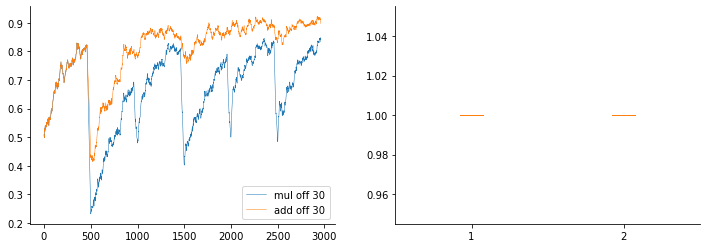

In [2]:
exp_name = 'controlled_md/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'mul off', 2:'add off', 3:'mul_off'}
# vars = [(var1, var2) for var1 in [3] for var2 in [0, 1, 2,3,4,5,10,20,30,40,50,100,150,200]]
# vars = [(var1, var2) for var1 in [1] for var2 in [0, 1, 2,3,4,50,100,150,200]]
vars = [(var1, var2) for var1 in [1,2] for var2 in [30]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

fig, axes = plt.subplots(1,2 , figsize=[12,4])
ax = axes[0]
means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]
    conf_files =   [os.path.join(results_folder+exp_name,file) for file in config_files if re.search(regex, file)]
    if len(comp_files) > 0:
        performances, mods =[], []
        for log_file, config_file in zip (comp_files, conf_files):
            log = np.load(log_file, allow_pickle=True).item()
            if log.md_context_modulation > 0.8 : 
                performances.append(log.corrects)
                mods.append(log.md_context_modulation)
        smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
        sp = np.stack(smooth_performances)
        spmean = np.mean(sp, axis=0)    
        spstd = np.std(sp, axis=0)    
        means.append(spmean)
        stds.append(spstd)
        ax.plot(range(len(spmean)), spmean, label=label, linewidth=0.5)
        # ax.fill_between(range(len(spmean)), spmean-spstd, spmean+spstd, alpha=.4)
        md_modulations.append(mods)
    else:
        print(f'no files found for {label}')
ax.legend()

ax = axes[1]
_=ax.boxplot(md_modulations)
# plt.savefig(f'./exports/ofc.{file_format}', format=file_format, dpi=300)






In [12]:
md_modulations[0]


[0.8602233333333357]

In [4]:
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'mul off', 2:'add off', 3:'mul_off'}
vars = [(var1, var2) for var1 in [1] for var2 in [1 ]]
# vars = [(var1, var2) for var1 in [3] for var2 in [0,1, 5, 10,20,30,40,200]]
regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_0.0" for var1, var2 in vars]  
labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

means, stds, md_modulations = [], [], []
for label, regex in zip (labels, regexes):
    comp_files =  [os.path.join(results_folder+exp_name,file) for file in log_files if re.search(regex, file)]


In [5]:
comp_files

['./../results/mul_off/MD_ablation/log_0_1.0_1.0_0.0__12-29_21:53.npy',
 './../results/mul_off/MD_ablation/log_10_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_1_1.0_1.0_0.0__12-29_21:53.npy',
 './../results/mul_off/MD_ablation/log_2_1.0_1.0_0.0__12-29_21:53.npy',
 './../results/mul_off/MD_ablation/log_3_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_4_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_5_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_6_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_7_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_8_1.0_1.0_0.0__12-29_21:50.npy',
 './../results/mul_off/MD_ablation/log_9_1.0_1.0_0.0__12-29_21:50.npy']

In [16]:
log = np.load(comp_files[-1], allow_pickle=True).item()

In [17]:
log.md_context_modulation

0.9068800000000036

In [19]:
log.MDrates.shape

(3000, 200, 2)